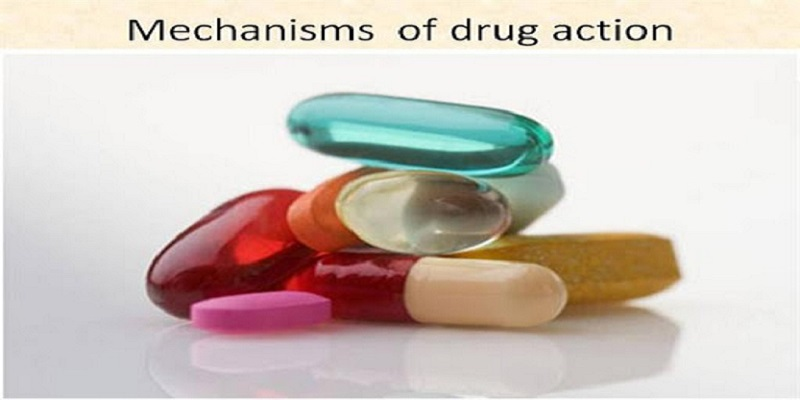

# About

The following is an analysis of the data in the MOA-challenge. The aim of this challenge is to classify drugs based on their biological activity. The given data consists of gene expression data and cell viability data. We are to predict the mechanism of action response(s) for different samples. This is a multi-label classification problem where one sample might have multiple MoAs. The evaluation metric for this challenge is column wise logloss.

The data is given to us in the form of train.csv and train_targets_scored.csv. The target MoAs in this file need to be predicted and are scored. In addition we also have have a file with additional MoA targets that are not scored but can be used for context analysis.
A link to my model for this competition may be found [here](https://www.kaggle.com/bibhash123/moa-simple-transfer-model-using-tensorflow-keras)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import pandas_profiling

## First look on the data

In [ ]:
train_data= pd.read_csv('../input/lish-moa/train_features.csv')
test_data = pd.read_csv('../input/lish-moa/test_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_non_scored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

In [ ]:
print("Train Data: ")
print("Shape:"+str(train_data.shape))
train_data.head(3)

In [ ]:
print("Test Data\nShape:"+str(test_data.shape))
test_data.head(3)

In [ ]:
print("Targets Scored:\nShape:"+str(train_targets_scored.shape))
train_targets_scored.head(3)

In [ ]:
print("Targets Non scored:\nShape:"+str(train_targets_non_scored.shape))
train_targets_non_scored.head(3)

In [ ]:
train_gs = train_data.iloc[:,train_data.columns.map(lambda x: x[0:2])=='g-']
train_cs = train_data.iloc[:,train_data.columns.map(lambda x: x[0:2])=='c-']
print("Gene expression data Number of columns: "+str(train_gs.shape[1]))
print("cell viability data Number of columns: "+ str(train_cs.shape[1]))

We observe that the dataset consists of 772 columns for gene expression data and 100 columns for cell viability data. In addition cp_type indicate the type of treatment, whether the sample was treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle). Control perturbations have no MoAs. cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

In [ ]:
print("Mean:"+str(pd.concat([train_gs,train_cs],axis=1).values.mean()))
print("Std:"+str(pd.concat([train_gs,train_cs],axis=1).values.std()))
plt.figure(figsize=(5,5))
sns.distplot(pd.concat([train_gs,train_cs],axis=1).values)
plt.title('combined gene expression and cell viability')
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.distplot(train_gs['g-0'],color='pink')
plt.title('g-0')
plt.subplot(2,2,2)
sns.distplot(train_gs['g-100'],color='pink')
plt.title('g-100')
plt.subplot(2,2,3)
sns.distplot(train_cs['c-1'],color='pink')
plt.title('c-0')
plt.subplot(2,2,4)
sns.distplot(train_cs['c-80'],color='pink')
plt.title('c-80')

It is observed that the all gene expression and cell viabiity columns fit a normal distribution. Also the cell viability data appears to be clipped at -10 and gene expression data at -10 and 10 respectively. This is evident from the peaks observed in the distribution graph

In [ ]:
print("Gene expression data statistics: ")
print("  Mean: "+str(train_gs.values.mean()))
print("  Std: "+str(train_gs.values.std()))
print("  Max: "+str(train_gs.values.max()))
print("  Min: "+str(train_gs.values.min()))
print('\nCell viability data statistics: ')
print("  Mean: "+str(train_cs.values.mean()))
print("  Std: "+str(train_cs.values.std()))
print("  Max: "+str(train_cs.values.max()))
print("  Min: "+str(train_cs.values.min()))

### cp_time, cp_type and cp_dose

In [ ]:
plt.figure(figsize=(5,12))
plt.subplot(3,1,1)
splot = sns.countplot(train_data["cp_type"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('cp_type')
plt.subplot(3,1,2)
sns.countplot(train_data['cp_time'],hue=train_data['cp_type'])
plt.title('cp_time vs cp_type')
plt.subplot(3,1,3)
sns.countplot(train_data['cp_dose'],hue=train_data['cp_type'])
plt.title('cp_dose vs cp_type')
plt.tight_layout()

## Analysing the targets

### Scored Targets

In [ ]:
print("Number of scored targets: "+str(train_targets_scored.shape[1]))

39.3% of the training samples have 0 MoA activation. A majority of samples(52.6%) have one MoA activation. At max a sample has 7 MoA activations. 

In [ ]:
out = dict()
arr=train_targets_scored.drop('sig_id',axis=1).values==1
for a in range(len(arr)):
    o=np.sum(arr[a])
    if o not in out.keys():
        out[o]=1
    else:
        out[o]+=1
length = 23814
plt.figure(figsize=(7,7))
splot = sns.barplot(x=list(out.keys()),y=list(out.values()))
for p in splot.patches:
    splot.annotate(format(p.get_height()*100/length, '.1f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel('Number of MoAs in sample')
plt.ylabel('Count')
plt.title('Percentage of samples with MoA counts')

In [ ]:
cor = train_targets_scored.drop('sig_id',axis=1).corr()

It is observed that most drugs are not at all correlated with the exception of a few pairs

In [ ]:
cor = train_targets_scored.drop('sig_id',axis=1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor)

The drug pairs that have a correlation higher than 0.7 are as follows

In [ ]:
df = pd.DataFrame(columns=['drug_a','drug_b','corr'])
for j in range(len(cor)):
    for i in range(len(cor)):
        if cor.iloc[i,j]>=0.7 and cor.iloc[i,j]!=1.0:
            df = pd.concat([df,pd.DataFrame({'drug_a':[cor.columns[j]],'drug_b':[cor.columns[i]],'corr':[cor.iloc[i,j]]})],axis=0)
df

### Non Scored Targets

In [ ]:
print("Number of non scored targets: "+str(train_targets_non_scored.shape[1]))

With a combination of the scored and non scored targets we see that 23.2% of the samples have no MoA activation. Out of this 7% of samples are accounted for by the fact that their cp_type is control perturbation and hence no MoA is expected.

In [ ]:

out = dict()
arr=pd.concat([train_targets_scored.drop('sig_id',axis=1),train_targets_non_scored.drop('sig_id',axis=1)],axis=1).values==1
for a in range(len(arr)):
    o=np.sum(arr[a])
    if o not in out.keys():
        out[o]=1
    else:
        out[o]+=1
length = 23814
plt.figure(figsize=(7,7))
splot = sns.barplot(x=list(out.keys()),y=list(out.values()))
for p in splot.patches:
    splot.annotate(format(p.get_height()*100/length, '.1f')+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel('Number of MoAs in sample')
plt.ylabel('Count')
plt.title('Percentage of samples with MoA counts')

# Feature Relationships

Looking at the plot for cell viability data of a sample, it does not appear to be completely random and thus might have interdependence. Thus sequential models may be used to process the cell viability data.

**Note:** The above conclusion is purely based on speculation. A verification from someone with domain knowledge is appreciated

In the case of the gene expression profile, in the work published in American Society for Microbiology journal, [Hutter et. al.](https://aac.asm.org/content/48/8/2838) conclude that after treatment with a particular sample, a linear svm may be used to classify the MoA based on the gene expression profile data. A linear svm per class of MoA was used in their work. In our case however the number of scored MoA classes are large. Therfore perhaps a deep neural net might perform well in predicting the MoA classes.

In [ ]:
genes = [col for col in train_data if col.startswith('g-')]
cells = [col for col in train_data if col.startswith('c-')]

## Genes correlation

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(train_data.loc[:,genes].corr(),cmap='viridis')

## Cell correlations

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(train_data.loc[:,cells].corr(),cmap='viridis')

* Many cell viabilities have high correlation with each other

In [ ]:
plt.plot(train_cs.iloc[1,:])
plt.title('cell viability data for second sample')

In [ ]:
cor = train_gs.corr()

It is also observed that certain gene pairs have high negative correlation

In [ ]:
df = pd.DataFrame(columns=['gene_a','gene_b','corr'])
for j in range(len(cor)):
    for i in range(len(cor)):
        if cor.iloc[i,j]<=-0.8 and cor.iloc[i,j]!=1.0:
            df = pd.concat([df,pd.DataFrame({'gene_a':[cor.columns[j]],'gene_b':[cor.columns[i]],'corr':[cor.iloc[i,j]]})],axis=0)
df

**Some gene expressions coloured with respect to treatment type:** cyan represents trt-vehicle and orange trt_cp

In [ ]:
cp_1 = train_data[train_data['cp_type']=='trt_cp']
cp_2 = train_data[train_data['cp_type']!='trt_cp']
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(cp_1['g-0'],color='orange',hist=False)
sns.distplot(cp_2['g-0'],color='cyan',hist=False)
plt.title('g-0')
plt.subplot(2,2,2)
sns.distplot(cp_1['g-100'],color='orange',hist=False)
sns.distplot(cp_2['g-100'],color='cyan',hist=False)
plt.title('g-100')
plt.subplot(2,2,3)
sns.distplot(cp_1['g-500'],color='orange',hist=False)
sns.distplot(cp_2['g-500'],color='cyan',hist=False)
plt.title('g-500')
plt.subplot(2,2,4)
sns.distplot(cp_1['g-600'],color='orange',hist=False)
sns.distplot(cp_2['g-600'],color='cyan',hist=False)
plt.title('g-600')

**Cell viability for some samples coloured with respect to treatment type:** cyan represents trt_vehicle and orange trt_cp

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(cp_1['c-1'],color='orange',hist=False)
sns.distplot(cp_2['c-1'],color='cyan',hist=False)
plt.title('c-1')
plt.subplot(2,2,2)
sns.distplot(cp_1['c-20'],color='orange',hist=False)
sns.distplot(cp_2['c-20'],color='cyan',hist=False)
plt.title('c-20')
plt.subplot(2,2,3)
sns.distplot(cp_1['c-40'],color='orange',hist=False)
sns.distplot(cp_2['c-40'],color='cyan',hist=False)
plt.title('c-40')
plt.subplot(2,2,4)
sns.distplot(cp_1['c-50'],color='orange',hist=False)
sns.distplot(cp_2['c-50'],color='cyan',hist=False)
plt.title('c-50')

For gene expression with respect to treatment type the distributions for gene expression have slighty more variance compared to the same plot for cell viability.

**Some gene expressions coloured with respect to treatment duration:** cyan represents 24, orange 48 and blue 72

In [ ]:
cp_1 = train_data[train_data['cp_time']==24]
cp_2 = train_data[train_data['cp_type']!=48]
cp_3 = train_data[train_data['cp_type']!=72]
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(cp_1['g-0'],color='orange',hist=False)
sns.distplot(cp_2['g-0'],color='cyan',hist=False)
sns.distplot(cp_3['g-0'],color='blue',hist=False)
plt.title('g-0')
plt.subplot(2,2,2)
sns.distplot(cp_1['g-100'],color='orange',hist=False)
sns.distplot(cp_2['g-100'],color='cyan',hist=False)
sns.distplot(cp_3['g-100'],color='blue',hist=False)
plt.title('g-100')
plt.subplot(2,2,3)
sns.distplot(cp_1['g-500'],color='orange',hist=False)
sns.distplot(cp_2['g-500'],color='cyan',hist=False)
sns.distplot(cp_3['g-500'],color='blue',hist=False)
plt.title('g-500')
plt.subplot(2,2,4)
sns.distplot(cp_1['g-600'],color='orange',hist=False)
sns.distplot(cp_2['g-600'],color='cyan',hist=False)
sns.distplot(cp_3['g-600'],color='blue',hist=False)
plt.title('g-600')

**cell viability of some samples coloured with respect to treatment duration:** cyan represents 24, orange 48 and blue 72

In [ ]:

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(cp_1['c-1'],color='orange',hist=False)
sns.distplot(cp_2['c-1'],color='cyan',hist=False)
sns.distplot(cp_3['c-1'],color='blue',hist=False)
plt.title('c-1')
plt.subplot(2,2,2)
sns.distplot(cp_1['c-20'],color='orange',hist=False)
sns.distplot(cp_2['c-20'],color='cyan',hist=False)
sns.distplot(cp_3['c-20'],color='blue',hist=False)
plt.title('c-20')
plt.subplot(2,2,3)
sns.distplot(cp_1['c-40'],color='orange',hist=False)
sns.distplot(cp_2['c-40'],color='cyan',hist=False)
sns.distplot(cp_3['c-40'],color='blue',hist=False)
plt.title('c-40')
plt.subplot(2,2,4)
sns.distplot(cp_1['c-50'],color='orange',hist=False)
sns.distplot(cp_2['c-50'],color='cyan',hist=False)
sns.distplot(cp_3['c-50'],color='blue',hist=False)
plt.title('c-50')

****cell viability and gene expression of some samples coloured with respect to dose:**** cyan represents D0 and orange D1

In [ ]:
cp_1 = train_data[train_data['cp_dose']=='D0']
cp_2 = train_data[train_data['cp_dose']!='D1']
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(cp_1['g-0'],color='orange',hist=False)
sns.distplot(cp_2['g-0'],color='cyan',hist=False)
plt.title('g-0')
plt.subplot(2,2,2)
sns.distplot(cp_1['g-100'],color='orange',hist=False)
sns.distplot(cp_2['g-100'],color='cyan',hist=False)
plt.title('g-100')
plt.subplot(2,2,3)
sns.distplot(cp_1['g-500'],color='orange',hist=False)
sns.distplot(cp_2['g-500'],color='cyan',hist=False)
plt.title('g-500')
plt.subplot(2,2,4)
sns.distplot(cp_1['g-600'],color='orange',hist=False)
sns.distplot(cp_2['g-600'],color='cyan',hist=False)
plt.title('g-600')

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(cp_1['c-1'],color='orange',hist=False)
sns.distplot(cp_2['c-1'],color='cyan',hist=False)
plt.title('c-1')
plt.subplot(2,2,2)
sns.distplot(cp_1['c-20'],color='orange',hist=False)
sns.distplot(cp_2['c-20'],color='cyan',hist=False)
plt.title('c-20')
plt.subplot(2,2,3)
sns.distplot(cp_1['c-40'],color='orange',hist=False)
sns.distplot(cp_2['c-40'],color='cyan',hist=False)
plt.title('c-40')
plt.subplot(2,2,4)
sns.distplot(cp_1['c-50'],color='orange',hist=False)
sns.distplot(cp_2['c-50'],color='cyan',hist=False)
plt.title('c-50')

# Take away points

* Since samples with cp_type "trt_vehicle" don't have any MoA activation, after prediction those sample targets can manually be set to 0. However the important point here is that the columns with cp_type "trt_vehicle"
* The gene expression and cell viability combined, appear to follow a normal distribution as do individual columns. This may be because the data has already been normalized. On another hand it may also bear some significance in perspective of the domain (Unsure about this).
* The cell viability data show some kind of uniformity which might imply that sequential models may perform well on this part. (Again requires a review from someone with domain knowledge).
* For gene expression with respect to treatment type the distributions for gene expression have slighty more variance compared to the same plot for cell viability.
* From similar plots to those mentioned in previous point, for cp_time and cp_dose it is observed that identical distributions are obtained for each category.
* Most drug pairs are not at all correlated with the exception of a few pairs.
* Certain gene pairs are highly correlated with each other

# Areas that require attention

A very important aspect of this data is to determine why the rows corresponding to control perturbation are provided. The discussion by [Matthew Masters](https://www.kaggle.com/c/lish-moa/discussion/184005) is informative in this regard. The following may or may not be the use of these rows
* The trt_cp rows may be normalized using ctl_vehicle rows provided we know the underlying pairing, meaning the data of which control sample was used for which treatment sample.
* Let's have another look at the countplot for cp_type this time with both train and test set combined:
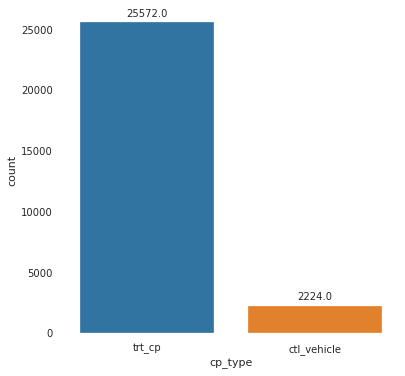 
* What is interesting to note here is looking at the values for this plot 25572/2224 is rougly 11.5(let's say 12). Now if a drug sample is applied at different doses (D0 and D1) and let's say for each dose the data was collected at times 24,48 and 72 hrs, then each drug sample should 6 corresponding rows ( may be some other factor is also present owing to which the number of rows may be more or less).
* Therefore finding a way to associate each sample with corresponding control sample is important. Discussions suggest the use of KNN search for the same. However I haven't found a way to do so effectively. This might prove to be a crucial aspect of the competition.

### **Note: The above discussion is my take on the data. Some of the observation may not be correct. Any advice or suggestion is welcome.**